## HEXAGONAL GRID GENERATION AND RASTER ZONAL STATISTICS 

#### The objective of this Notebook is to generate hexagonal tesselations that aggregate pixel values (by mean or median) of any Raster. It has been created using mainly rasterio, geopandas, and rasterstats python packages. The final output of the notebook, is a .GeoJSON with hexagonal geometries.

#### In the folder where this notebook is hosted, you will find the Area of Interest (AOI) GeoJSON and a Landsat 8 Raster image for testing.


#### 1. Import Required Packages

In [25]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import h3
from shapely.geometry import Polygon
from rasterstats import zonal_stats
import pandas as pd

#### 2. Define Input Raster and Area of Interest (.geojson)

In [26]:
RASTER = r"C:\Users\fcam_\OneDrive - Universidad de los Andes\Copernicus_Master_Courses\Summer_Semester_2023\SOFTWARE_DEVELOPMENT\PLUS_softwaredev_2023_Felipe_Camacho\A3_Hexagonal_Grid\Landsat8_2018-08-01.tif"
AOI = gpd.read_file(r"C:\Users\fcam_\OneDrive - Universidad de los Andes\Copernicus_Master_Courses\Summer_Semester_2023\SOFTWARE_DEVELOPMENT\PLUS_softwaredev_2023_Felipe_Camacho\A3_Hexagonal_Grid\AOI.geojson")

#### 3. Open and Display the Raster

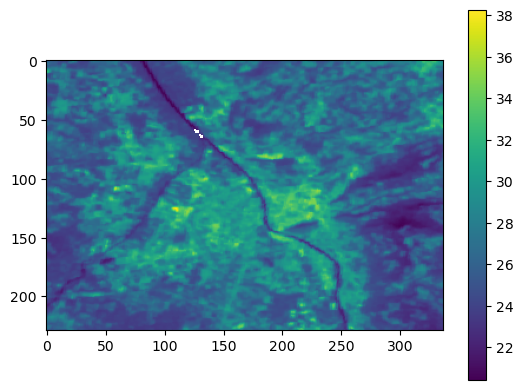

In [27]:
# Open the input raster file
with rasterio.open(RASTER) as src:
    # Read the raster data as a numpy array
    raster_data = src.read(1)
    # Get the spatial transformation information
    transform = src.transform
    # Get the raster extent
    extent = src.bounds
    
# Display the raster
plt.imshow(raster_data, cmap='viridis')
plt.colorbar()
plt.show()   

#### 4. Generate Hexagons withing the Area of Interest

In [28]:
# Generate hexagons within the AOI using H3 library
hexagons = h3.polyfill(AOI.geometry[0].__geo_interface__, 9, geo_json_conformant=True)

# Define a lambda function to convert H3 hexagon IDs to Shapely Polygon objects
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

# Create a GeoSeries of polygons from the hexagons, with hexagon IDs as index
hexagons_geoseries = gpd.GeoSeries(list(map(polygonise, hexagons)), index=hexagons, crs="EPSG:4326")

#### 5. Visualize Hexagons


Text(0.5, 1.0, '2436 Hexagons')

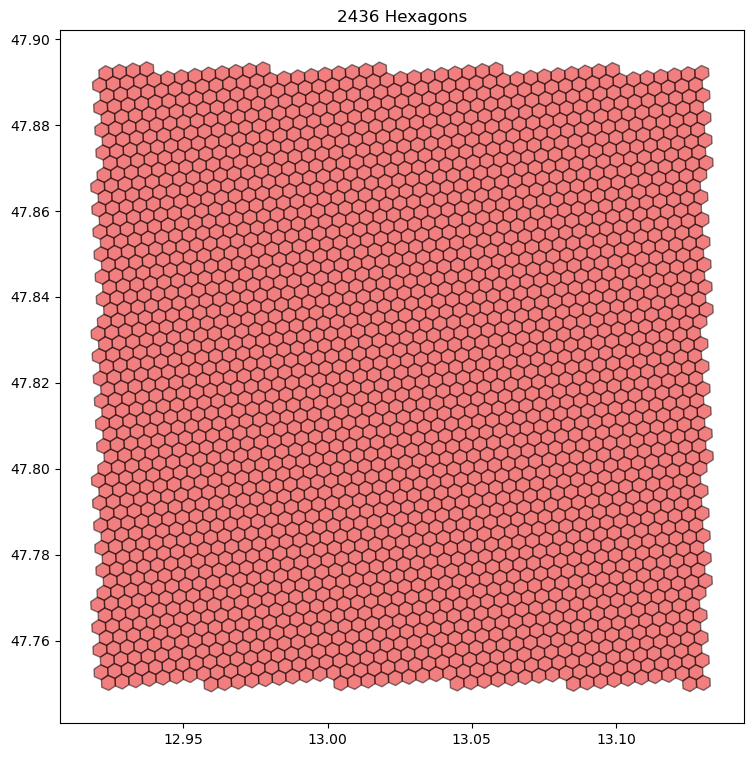

In [29]:
ax = hexagons_geoseries.plot(alpha=0.5, color="xkcd:red",edgecolor = "black", figsize=(9, 9))
ax.set_title(f"{hexagons_geoseries.shape[0]} Hexagons")

#### 6. Calculate Zonal Statistics

In [30]:
# Calculate zonal statistics for the raster within each polygon in hexagons_geoseries
statistics = zonal_stats(hexagons_geoseries, RASTER, stats="mean min max median")

# Convert the statistics to a pandas DataFrame
statistics = pd.DataFrame(statistics)

# Reset the index of hexagons_geoseries, dropping the existing index
hexagons_geoseries = hexagons_geoseries.reset_index(drop=True)

#### 7. Join Statistics and Hexagons

In [31]:
# Concatenate hexagons_geoseries and statistics along the columns axis
hexagons_statistics = pd.concat([hexagons_geoseries, statistics], axis=1)

# Extract the first column as the geometry
geometry = hexagons_statistics[0]

# Create a GeoDataFrame from hexagons_statistics with the specified CRS and using the extracted geometry column
hexagons_statistics_gdf = gpd.GeoDataFrame(hexagons_statistics, crs="EPSG:4326", geometry=geometry)

# Print the hexagons_statistics_gdf GeoDataFrame
print(hexagons_statistics_gdf)




                                                      0        min        max  \
0     POLYGON ((12.95755 47.84263, 12.95768 47.84088...  29.121548  30.679958   
1     POLYGON ((13.02792 47.75508, 13.02804 47.75333...  25.808620  29.241085   
2     POLYGON ((12.98789 47.78409, 12.98802 47.78235...  25.432125  30.927212   
3     POLYGON ((13.09656 47.75681, 13.09669 47.75506...  23.721676  26.698879   
4     POLYGON ((13.06233 47.80463, 13.06245 47.80288...  26.292263  30.616360   
...                                                 ...        ...        ...   
2431  POLYGON ((13.02754 47.76032, 13.02767 47.75857...  25.884243  28.672268   
2432  POLYGON ((13.06400 47.88098, 13.06413 47.87923...  25.948025  28.244503   
2433  POLYGON ((12.97814 47.88600, 12.97827 47.88426...  22.502407  24.166012   
2434  POLYGON ((13.08441 47.86125, 13.08453 47.85950...  25.481930  29.024929   
2435  POLYGON ((13.12305 47.78479, 13.12318 47.78305...  23.606106  25.966885   

           mean     median 

#### 8. Display Polygons as Choropleth map (with "mean" values)

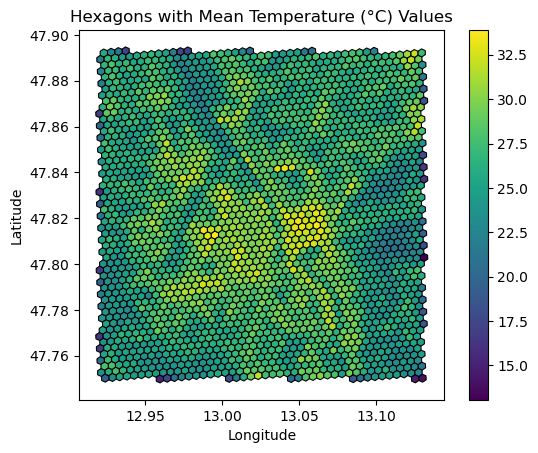

In [32]:
# Plot the hexagons with colors based on the 'mean' column
hexagons_statistics_gdf.plot(column='mean', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True)

# Set plot title and axis labels
plt.title('Hexagons with Mean Temperature (°C) Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

#### 9. Export Geodata Frame as GeoJson



In [33]:
# Drop the '0' column which contains the geometry as string.
hexagons_statistics_gdf = hexagons_statistics_gdf.drop(0, axis=1)  

# Export as GeoJSON
hexagons_statistics_gdf.to_file('Hexagonal_Grid_Salzburg.geojson', driver='GeoJSON')  


#### Created by: Felipe Camacho H based on the following documentation:

#### https://pypi.org/project/rasterstats/

#### https://pythonhosted.org/rasterstats/manual.html

#### https://github.com/stepankuzmin/h3-polyfill